# Tacotron 2

## References: 

[Tacotron2](https://arxiv.org/abs/1712.05884) 
[Location-Sensitive Attention](https://arxiv.org/abs/1506.07503) 
[Librosa](https://librosa.github.io/librosa/) 
[LibreSpeech Dataset](http://www.openslr.org/12/)

In [0]:
# automatic reload and inline plot
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Create Model Components

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, CuDNNLSTM, Bidirectional, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os
!pip3 install librosa

import librosa
import librosa.display
import numpy as np

In [0]:
X = tf.placeholder(tf.float32, shape=[None, 10], name='input')

### Encoder

In [0]:
layers = []

#Adds embedding layer to model with input of 1000, output 512, and input length of 10
layers.append(Embedding(1000, 512, input_length=10))

'''
Creates 3 convolutional layers and adds to the model. Output of 512, kernel of 5, stride of 1, and padding
BatchNormalization makes the layers more independent of each other
Gives activation function 'relu' to each layer (Negatives to zero)
Adds dropout of .5 to each layer
'''
for _ in range(3):
  conv_bn_dp = []
  conv_bn_dp.append(Conv1D(512, kernel_size=5, strides=1, padding='same'))
  conv_bn_dp.append(BatchNormalization())
  conv_bn_dp.append(Activation("relu"))
  conv_bn_dp.append(Dropout(0.5))
  layers += conv_bn_dp

  
#Creates a bidirectional LSTM with units of 256 in each direction  
layers.append(Bidirectional(CuDNNLSTM(256)))

#Adds all previously created layers to the encoder
encoder = Sequential(layers)

### Decoder Components

In [0]:
'''
Creation of prenet layers. Both contain:
Output of 256
Activation function of relu
First layer also contains an input shape of 256
'''
layers_prenet = []
layers_prenet.append(Dense(256,"relu", input_shape=(256,)))
layers_prenet.append(Dense(256, "relu"))

prenet = Sequential(layers_prenet)

#AttentionNetwork goes here


# TODO: change input_shape, will change when finished with attention block
lstm_decoder = Sequential([CuDNNLSTM(1024, input_shape=(256,1))]) 

In [0]:
# Input shape: Sum(LSTM_outputs + Attention_outputs)
# Output shape: size of spectrogram
# TODO: Change in and out size, will change when finished with attention block
target_frame = Sequential([Dense(1402, input_shape=(1024,1))])

In [0]:
postnet_layers = []

'''
Creation of the first layer in the postnet, which is a Convolutional layer. Contains the following as specified in our notes:
Output: 512
Kernel Size: 5
Strides: 1
Padding: Same
Input Shape: 1024x1
Includes Batch Normalization
Activation function of tanh
Dropout of 0.5
'''
postnet_layers.append(Conv1D(512, kernel_size = 5, strides = 1, padding = 'same', input_shape=(1024,1)))
postnet_layers.append(BatchNormalization())
postnet_layers.append(Activation("tanh"))
postnet_layers.append(Dropout(0.5))

'''
Creates and adds three more Convolutional layers to the postnet. These layers are different from the first layer
as they don't have an input shape:
Output: 512
Kernel Size: 5
Strides: 1
Padding: Same
Includes Batch Normalization
Activation function of tanh
Dropout of 0.5
'''
for i in range(3):
  conv_bn_dp = []
  conv_bn_dp.append(Conv1D(512, kernel_size = 5, strides = 1, padding = 'same'))
  conv_bn_dp.append(BatchNormalization())
  conv_bn_dp.append(Activation("tanh"))
  conv_bn_dp.append(Dropout(0.5))
  postnet_layers += conv_bn_dp

'''
The final layer to the postnet, also a Convolutional layer:
Output:512
Kernel Size: 5
Strides: 1
Padding: Same
Includes Batch Normalization
'''

postnet_layers.append(Conv1D(512, kernel_size = 5, strides = 1, padding = 'same'))
postnet_layers.append(BatchNormalization())

#Assigns all the postnet layers to the actual postnet
postnet = Sequential(postnet_layers)

In [0]:
# Input shape: Sum(LSTM_outputs + Attention_outputs)
# TODO: Change in shape, will change when finished with attention block
stop_token = Sequential([Dense(1, 'sigmoid', input_shape=(1024,))])

## Convert WAV to Mel Spectrogram

In [112]:
#Mounts google drive to colab.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
'''
Finds all .wav files in the Data folder and adds their
paths to a list.
'''
paths = []
for root, dirs, files in os.walk("drive/My Drive/Data/"):  
    for filename in files:
      if filename.endswith('.wav'):
        paths.append("drive/My Drive/Data/" + filename)

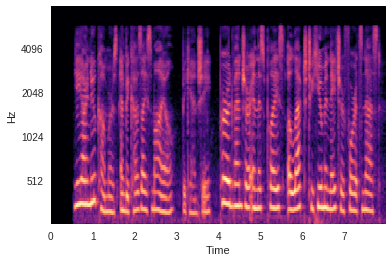

In [114]:
spectrograms = []

# Convert and Save mel spectorgram in as a numpy array to load later for training
# Loading from file will be faster than converting on the fly
#Additionally, prints the mel-spectogram
for f in paths:
  y, sr = librosa.load(f)
  m = librosa.feature.melspectrogram(y=y, sr=sr)
  D = np.abs(librosa.stft(y))**2
  mel_spec = librosa.power_to_db(m,ref=np.max)
  librosa.display.specshow(mel_spec, y_axis='mel', fmin=7.5, fmax=8000, x_axis='time')
  np.save(f.split('.wav')[0], mel_spec)
  spectrograms.append(mel_spec)

## Convert transcript to vector of words

In [0]:
import pandas as pd

word_idx = {}

# Keep track of max words in audio/transcript.
# Used for post-padding, so all are same size
length = 0

with open('drive/My Drive/Data/transcript.txt') as infile:
    corpus = infile.readlines()

# Add words to index dictionary. {key: word, value: count}
for lines in corpus:
    line = lines.split(' ')
    if len(line) > length:
        length = len(line)
    for word in line:
        word = word.strip('\n')
        if word in word_idx:
            word_idx[word] += 1
        else:
            word_idx[word] = 1

# Sort index from greatest to lowest
sorted_idx = sorted(word_idx.items(), key=lambda kv: kv[1], reverse=True)

word_idx['PAD'] = 0

# Assign each word in index with number based on frequency
for i, key in zip(range(len(sorted_idx)), sorted_idx):
    word_idx[key[0]] = i + 1


word_encoding = []

# Encode all words
for lines in corpus:
    line = lines.split()
    encoding = np.zeros((1, length))
    i = 0
    for word in line:
        word = word.strip('\n')
        encoding[0, i] = word_idx[word]
        i += 1
    word_encoding.append(encoding)

n = np.asarray(word_encoding)
n = np.reshape(n, (5, length))

# Save dataFrame to csv file to load for training
df = pd.DataFrame(n)
df.to_csv('word_encoding.csv', sep=',', index=False, header=False)